## Set-up

In [168]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utils import geometric_median, geometric_medoid
from NMF_iter import normalize_curves

In [169]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [170]:
def initialize_W(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [220]:
n_components = 3 # Number of components for the matrix factorization
n_runs = 10000
smoothed = False

colormap = ListedColormap([colors[k] for k in range(n_components)])

# Process data

## Data matrix $X$

In [176]:
if smoothed:
    infile = 'data/daily_curves_pos_smoothed_13b_15min.csv'
else:
    infile = 'data/daily_curves_fixed.csv'
input_df = pd.read_csv(infile, index_col=0)
print(len(input_df))
input_df.head(3)

11646


0        1        2        3        4  \
Calabria_2021-01-02_Saturday     552.943  514.861  462.221  448.924  457.576   
Calabria_2021-01-03_Holiday      518.853  457.879  432.200  419.060  393.992   
Calabria_2021-01-04_Working day  540.431  450.024  434.019  432.949  435.210   

                                       5        6        7        8        9  \
Calabria_2021-01-02_Saturday     462.207  492.594  526.408  579.682  648.228   
Calabria_2021-01-03_Holiday      438.706  462.433  488.501  532.412  641.866   
Calabria_2021-01-04_Working day  457.071  516.980  625.155  691.067  885.798   

                                 ...       15       16       17       18  \
Calabria_2021-01-02_Saturday     ...  648.877  658.723  745.817  773.431   
Calabria_2021-01-03_Holiday      ...  678.540  666.579  730.333  764.207   
Calabria_2021-01-04_Working day  ...  845.339  798.132  870.231  891.262   

                                      19       20       21       22       23  \
Calabria_2021-01-02_Saturday     828.180  831.509  758.732  669.630  596.548   
Calabria_2021-01-03_Holiday      819.056  825.176  754.773  706.062  629.708   
Calabria_2021-01-04_Working day  980.735  926.445  845.014  756.975  688.183   

                                      24  
Calabria_2021-01-02_Saturday     518.853  
Calabria_2021-01-03_Holiday      540.431  
Calabria_2021-01-04_Working day  601.762  

[3 rows x 25 columns]

In [177]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11646


0        1        2        3        4  \
Calabria_2021-01-02_Saturday     552.943  514.861  462.221  448.924  457.576   
Calabria_2021-01-03_Holiday      518.853  457.879  432.200  419.060  393.992   
Calabria_2021-01-04_Working day  540.431  450.024  434.019  432.949  435.210   

                                       5        6        7        8        9  \
Calabria_2021-01-02_Saturday     462.207  492.594  526.408  579.682  648.228   
Calabria_2021-01-03_Holiday      438.706  462.433  488.501  532.412  641.866   
Calabria_2021-01-04_Working day  457.071  516.980  625.155  691.067  885.798   

                                 ...       19       20       21       22  \
Calabria_2021-01-02_Saturday     ...  828.180  831.509  758.732  669.630   
Calabria_2021-01-03_Holiday      ...  819.056  825.176  754.773  706.062   
Calabria_2021-01-04_Working day  ...  980.735  926.445  845.014  756.975   

                                      23       24    region  year  month  \
Calabria_2021-01-02_Saturday     596.548  518.853  Calabria  2021     01   
Calabria_2021-01-03_Holiday      629.708  540.431  Calabria  2021     01   
Calabria_2021-01-04_Working day  688.183  601.762  Calabria  2021     01   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  

[3 rows x 29 columns]

In [178]:
X = df.drop(unit_info.columns, axis=1)
# We want to keep a functional l1 norm of 1. In case of 15min interval load measures (so 97 measures), we normalise by the l1 norm of the vector divided by int(97 / 24) = 4
X = normalize_curves(X)
X.head()

0         1         2         3  \
Calabria_2021-01-02_Saturday     0.036819  0.034283  0.030778  0.029892   
Calabria_2021-01-03_Holiday      0.034625  0.030556  0.028842  0.027966   
Calabria_2021-01-04_Working day  0.030835  0.025677  0.024763  0.024702   
Calabria_2021-01-05_Working day  0.034956  0.031889  0.030023  0.029715   
Calabria_2021-01-06_Holiday      0.033561  0.029616  0.028412  0.028415   

                                        4         5         6         7  \
Calabria_2021-01-02_Saturday     0.030469  0.030777  0.032800  0.035052   
Calabria_2021-01-03_Holiday      0.026293  0.029277  0.030860  0.032600   
Calabria_2021-01-04_Working day  0.024831  0.026079  0.029497  0.035669   
Calabria_2021-01-05_Working day  0.028913  0.030107  0.033811  0.039218   
Calabria_2021-01-06_Holiday      0.027903  0.028700  0.029924  0.032797   

                                        8         9  ...        15        16  \
Calabria_2021-01-02_Saturday     0.038599  0.043163  ...  0.043207  0.043862   
Calabria_2021-01-03_Holiday      0.035530  0.042834  ...  0.045282  0.044483   
Calabria_2021-01-04_Working day  0.039430  0.050540  ...  0.048232  0.045538   
Calabria_2021-01-05_Working day  0.043283  0.053841  ...  0.046168  0.044271   
Calabria_2021-01-06_Holiday      0.035796  0.046258  ...  0.046951  0.044372   

                                       17        18        19        20  \
Calabria_2021-01-02_Saturday     0.049662  0.051500  0.055146  0.055368   
Calabria_2021-01-03_Holiday      0.048738  0.050998  0.054659  0.055067   
Calabria_2021-01-04_Working day  0.049652  0.050852  0.055957  0.052859   
Calabria_2021-01-05_Working day  0.047506  0.051417  0.051633  0.050358   
Calabria_2021-01-06_Holiday      0.047203  0.051273  0.052255  0.050949   

                                       21        22        23        24  
Calabria_2021-01-02_Saturday     0.050522  0.044589  0.039722  0.034549  
Calabria_2021-01-03_Holiday      0.050369  0.047118  0.042023  0.036065  
Calabria_2021-01-04_Working day  0.048213  0.043190  0.039265  0.034334  
Calabria_2021-01-05_Working day  0.046345  0.040047  0.035615  0.030337  
Calabria_2021-01-06_Holiday      0.048430  0.044395  0.040193  0.035674  

[5 rows x 25 columns]

# NMF

In [221]:
p = len(X.columns)

In [222]:
# Load the arrays from the .npz file
if smoothed:
    path = f'data/nmf_results/batch/{n_components}comp_smoothed_{n_runs}runs.npz'
else:  
    path = f'data/nmf_results/batch/{n_components}comp_{n_runs}runs.npz'
data = np.load(path)
print('Loaded ', path)

Loaded  data/nmf_results/batch/3comp_10000runs.npz


In [223]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
errors = data['errors']

## Clean results

In [224]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results = H_results[..., iterations > 100]
W_results = W_results[..., iterations > 100]
errors = errors[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(W_results.shape[2]))

3446 results clean


# Results analysis

## K-means clustering to group similar profiles

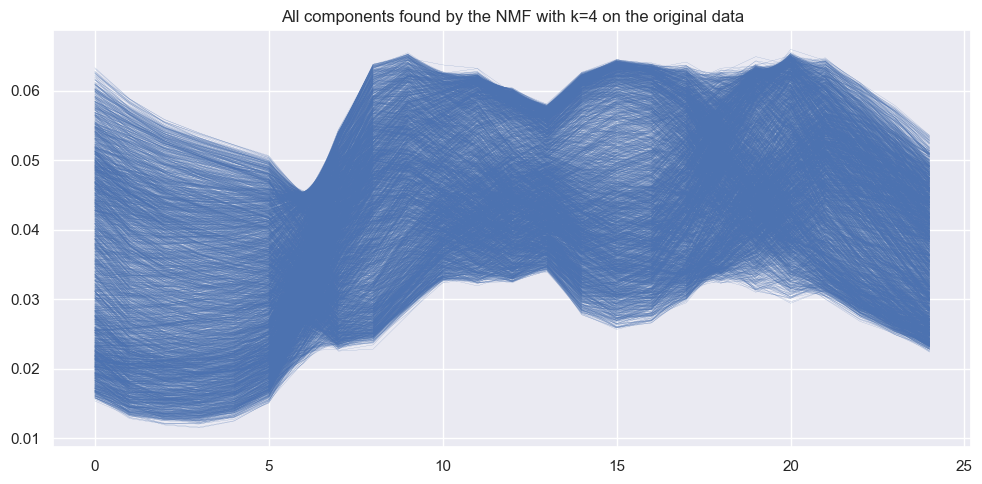

In [154]:
n_clean_runs = W_results.shape[2]
abscissa = [float(x) for x in X.columns]
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(n_clean_runs):
    for k in range(n_components):
        line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[0])
ax.set_title(f"All components found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
plt.tight_layout()

In [155]:
H_results_flat = H_results.transpose([0, 2, 1]).reshape((n_components * n_clean_runs, p)) # Flattening the array of profiles
kmeans = KMeans(n_clusters=n_components, n_init=10).fit(H_results_flat)

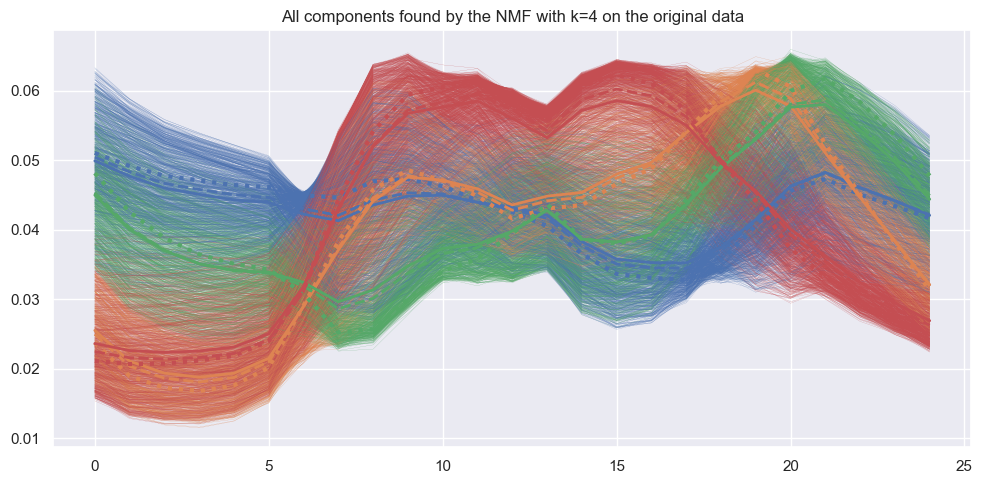

In [156]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    ax.plot(abscissa, H_results_flat[i, :], linewidth=0.1, color=colors[cluster_label])

# Plot cluster centroids
for i in range(n_components):
    ax.plot(abscissa, kmeans.cluster_centers_[i, :], linewidth=2, color=colors[i])
    ax.plot(abscissa, geometric_median(H_results_flat[kmeans.labels_ == i, :]), linewidth=2, linestyle='dashed', color=colors[i])
    ax.plot(abscissa, geometric_medoid(H_results_flat[kmeans.labels_ == i, :]), linewidth=3, linestyle='dotted', color=colors[i])
ax.set_title(f"All components found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
plt.tight_layout()
    

Let's plot per cluster

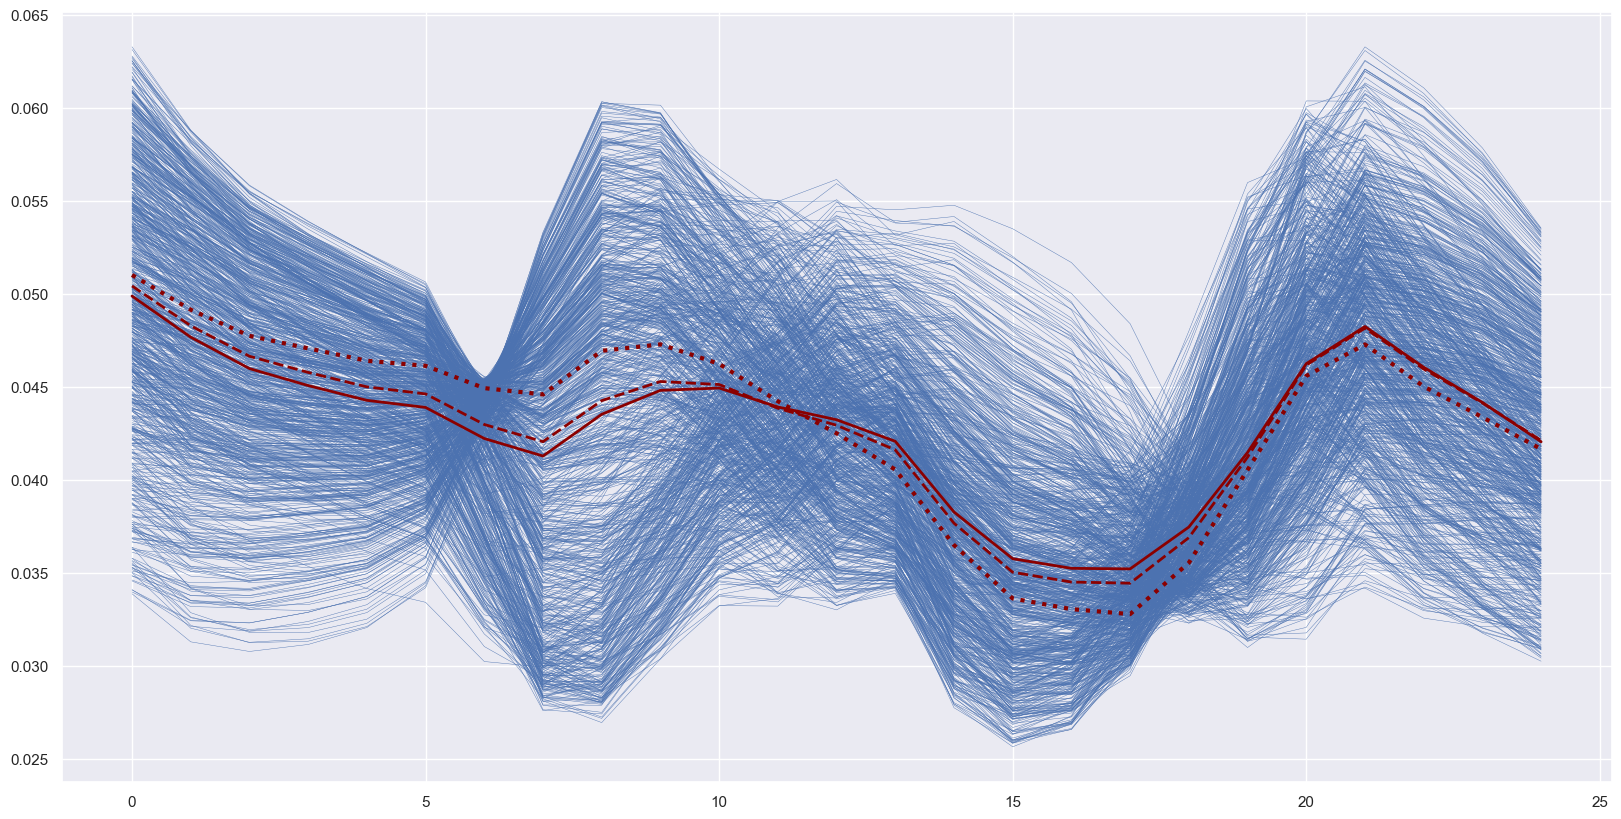

In [157]:
cluster = 0
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    if cluster_label == cluster:
        ax.plot(abscissa, H_results_flat[i, :], linewidth=0.3, color=colors[cluster_label])

# Plot cluster centroids
color = 'darkred'
# color = colors[cluster]
ax.plot(abscissa, kmeans.cluster_centers_[cluster, :], linewidth=2, color=color)
ax.plot(abscissa, geometric_median(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=2, linestyle='dashed', color=color)
ax.plot(abscissa, geometric_medoid(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=3, linestyle='dotted', color=color)
# ax.set_ylim((0,0.05))

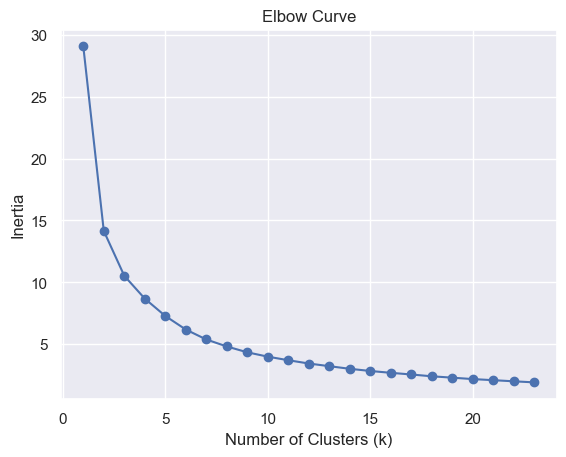

In [136]:
# Seems that there are more than 4 clusters of profiles. Let's try to find how much:

# Calculate inertia for different values of k
inertias = []
k_values = range(1, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

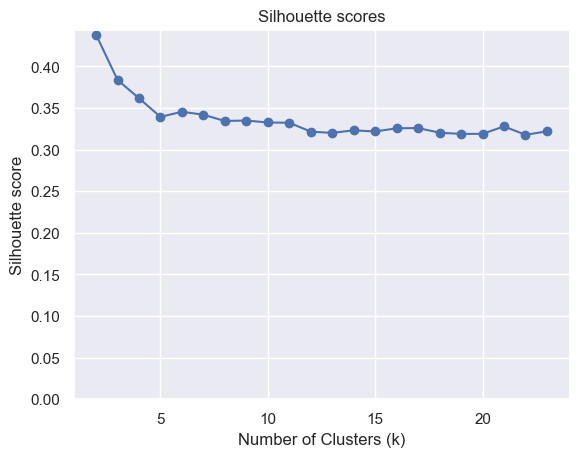

In [137]:
# Calculate silhouette score for different values of k
silhouette_scores = []
k_values = range(2, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    labels = kmeans.labels_
    score = silhouette_score(H_results_flat, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores')
plt.ylim(bottom=0)
plt.show()

<Axes: >

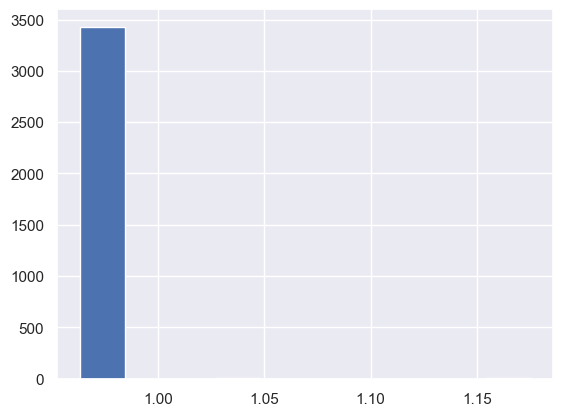

In [225]:
pd.Series(errors).hist()

## Select the solution that is compliant to the physics of the problem

### Cyclic profiles

We want to find solutions for which
$$\text{discontinuity}(H) = \sum_{k=1}^K(H_k(p) - H_k(1))^2$$

In [226]:
H_discontinuity = ((H_results[:, 0, :] - H_results[:, p-1, :])**2).sum(axis=0)

<Axes: >

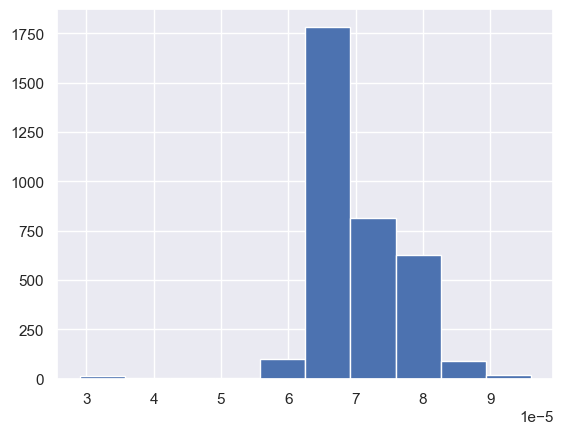

In [227]:
pd.Series(H_discontinuity).hist()

### Total distance of concentration vectors to simplex

The distance to the simplex of one observation $x$ to the simplex $\mathcal{S}(n)$ is the following
$$\text{dist}(x, \mathcal{S}(n)) = \inf_{\substack{y \in \mathcal{S}(n)}} d(x, y)$$

The point $y$ minimizing the distance is:
$$y = \frac{x}{||x||_1}$$

Here we will compute the sum of the distances to the simplex for all vector of concentrations of the matrix $W$

In [228]:
W_proj_simplex = W_results / W_results.sum(axis=1)[:, np.newaxis, :]
W_dist_simplex = np.sqrt(((W_results - W_proj_simplex)**2).sum(axis=1))
W_sum_dist_simplex = W_dist_simplex.sum(axis=0)

<Axes: >

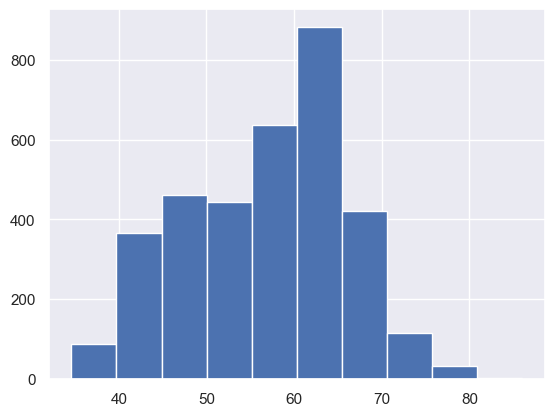

In [229]:
pd.Series(W_sum_dist_simplex).hist()

### Total distance of the components to the p-dimensional simplex

Similarly, the unit l1 norm constraint on the components, having necessarily positive coordinates, result in the components having to lie on the unit 1-sphere

In [230]:
H_proj_unit = np.empty_like(H_results)
for n in range(H_results.shape[2]):
    H_proj_unit[..., n] = normalize_curves(H_results[..., n])
H_dist_unit = np.sqrt(((H_results - H_proj_unit)**2).sum(axis=1))
H_sum_dist_unit = H_dist_unit.sum(axis=0)

<Axes: >

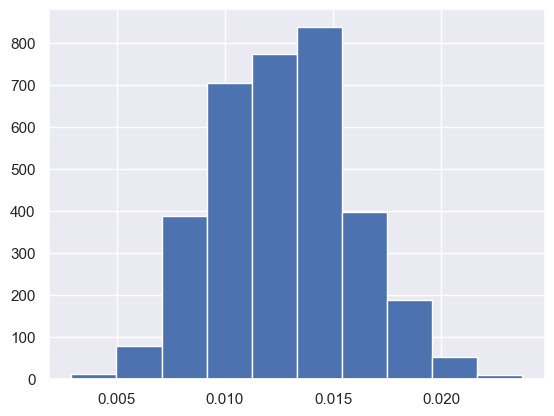

In [231]:
pd.Series(H_sum_dist_unit).hist()

### Scatterplot of the value of the two constraints

In [232]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_discontinuity,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex',
    yaxis_title='Discontinuity of the profiles',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [233]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_sum_dist_unit,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Sum of distance to the unit sphere for H',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [234]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=errors / int(X.shape[1] / 24),
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Reconstruction error',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [239]:
best_run = 2424

H = H_results[..., best_run]
W = W_results[..., best_run]

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Components found by the NMF'}, xlabel='Hour', ylabel='Load (MW)'>)

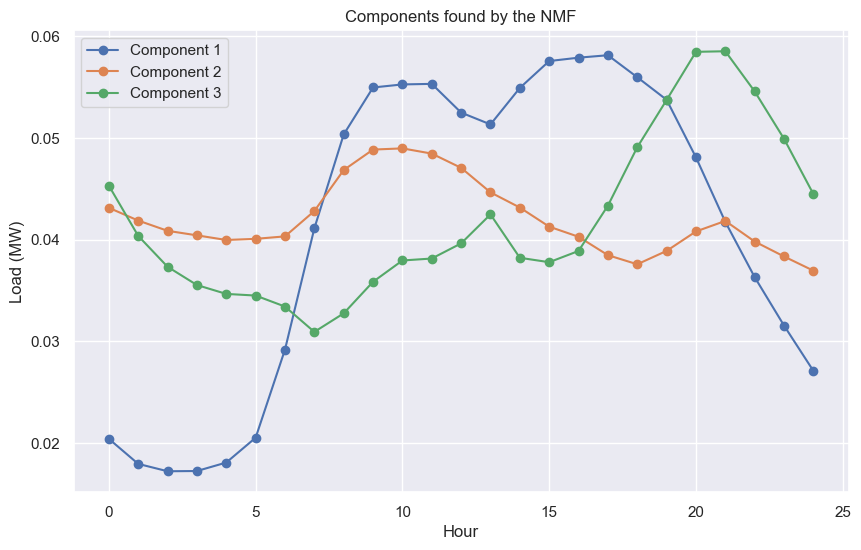

In [240]:
plot_components(H)

In [210]:
W = pd.DataFrame(W, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = df[unit_info.columns]
W

Component 1  Component 2   Component 3  \
Calabria_2021-01-02_Saturday        0.150695     0.338277  1.038375e-01   
Calabria_2021-01-03_Holiday         0.231433     0.391864  9.035892e-05   
Calabria_2021-01-04_Working day     0.145156     0.515055  1.222942e-01   
Calabria_2021-01-05_Working day     0.105477     0.351616  3.551269e-01   
Calabria_2021-01-06_Holiday         0.331441     0.376985  1.276966e-02   
...                                      ...          ...           ...   
South_2022-12-26_Holiday            0.100881     0.388611  8.947592e-07   
South_2022-12-27_Working day        0.036196     0.572270  1.288614e-01   
South_2022-12-28_Working day        0.095183     0.722712  5.380588e-11   
South_2022-12-29_Working day        0.203778     0.317533  2.553576e-01   
South_2022-12-30_Working day        0.000480     0.578882  8.104976e-03   

                                 Component 4    region  year month  \
Calabria_2021-01-02_Saturday        0.404100  Calabria  2021    01   
Calabria_2021-01-03_Holiday         0.376614  Calabria  2021    01   
Calabria_2021-01-04_Working day     0.219863  Calabria  2021    01   
Calabria_2021-01-05_Working day     0.184497  Calabria  2021    01   
Calabria_2021-01-06_Holiday         0.277207  Calabria  2021    01   
...                                      ...       ...   ...   ...   
South_2022-12-26_Holiday            0.517105     South  2022    12   
South_2022-12-27_Working day        0.260928     South  2022    12   
South_2022-12-28_Working day        0.195095     South  2022    12   
South_2022-12-29_Working day        0.220052     South  2022    12   
South_2022-12-30_Working day        0.419464     South  2022    12   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  
Calabria_2021-01-05_Working day  Working day  
Calabria_2021-01-06_Holiday          Holiday  
...                                      ...  
South_2022-12-26_Holiday             Holiday  
South_2022-12-27_Working day     Working day  
South_2022-12-28_Working day     Working day  
South_2022-12-29_Working day     Working day  
South_2022-12-30_Working day     Working day  

[11646 rows x 8 columns]

In [211]:
W[(W.region == 'North')&(W.daytype == 'Working day')].sort_index().tail(20)

Component 1  Component 2  Component 3  \
North_2022-12-01_Working day     0.241470     0.323370     0.372198   
North_2022-12-02_Working day     0.286173     0.290906     0.393093   
North_2022-12-05_Working day     0.246564     0.459058     0.272214   
North_2022-12-06_Working day     0.228966     0.317041     0.386402   
North_2022-12-07_Working day     0.231734     0.306813     0.412230   
North_2022-12-09_Working day     0.257864     0.378495     0.279485   
North_2022-12-12_Working day     0.234103     0.462175     0.276533   
North_2022-12-13_Working day     0.304079     0.323927     0.362494   
North_2022-12-14_Working day     0.289780     0.302598     0.390056   
North_2022-12-15_Working day     0.329299     0.323307     0.336262   
North_2022-12-16_Working day     0.309309     0.293944     0.391214   
North_2022-12-19_Working day     0.236930     0.429916     0.328298   
North_2022-12-20_Working day     0.278527     0.319626     0.379912   
North_2022-12-21_Working day     0.268483     0.328991     0.394279   
North_2022-12-22_Working day     0.254852     0.320673     0.418599   
North_2022-12-23_Working day     0.244585     0.260124     0.490706   
North_2022-12-27_Working day     0.170877     0.453608     0.248495   
North_2022-12-28_Working day     0.160043     0.424423     0.294398   
North_2022-12-29_Working day     0.184571     0.361299     0.330999   
North_2022-12-30_Working day     0.170656     0.370943     0.291327   

                              Component 4 region  year month      daytype  
North_2022-12-01_Working day     0.057768  North  2022    12  Working day  
North_2022-12-02_Working day     0.023171  North  2022    12  Working day  
North_2022-12-05_Working day     0.019237  North  2022    12  Working day  
North_2022-12-06_Working day     0.061309  North  2022    12  Working day  
North_2022-12-07_Working day     0.042331  North  2022    12  Working day  
North_2022-12-09_Working day     0.080404  North  2022    12  Working day  
North_2022-12-12_Working day     0.024418  North  2022    12  Working day  
North_2022-12-13_Working day     0.003551  North  2022    12  Working day  
North_2022-12-14_Working day     0.011521  North  2022    12  Working day  
North_2022-12-15_Working day     0.004794  North  2022    12  Working day  
North_2022-12-16_Working day     0.000080  North  2022    12  Working day  
North_2022-12-19_Working day     0.000651  North  2022    12  Working day  
North_2022-12-20_Working day     0.015713  North  2022    12  Working day  
North_2022-12-21_Working day     0.002511  North  2022    12  Working day  
North_2022-12-22_Working day     0.000636  North  2022    12  Working day  
North_2022-12-23_Working day     0.000025  North  2022    12  Working day  
North_2022-12-27_Working day     0.124752  North  2022    12  Working day  
North_2022-12-28_Working day     0.118694  North  2022    12  Working day  
North_2022-12-29_Working day     0.118553  North  2022    12  Working day  
North_2022-12-30_Working day     0.164324  North  2022    12  Working day

In [212]:
W_region = W.groupby('region')[[f"Component {k+1}" for k in range(n_components)]].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

Component 1  Component 2  Component 3  Component 4
region                                                          
Calabria         0.210131     0.284822     0.205036     0.300010
Centre.North     0.303375     0.289566     0.245831     0.161228
Centre.South     0.263945     0.308178     0.159148     0.268728
North            0.272473     0.272271     0.308508     0.146748
Sardinia         0.247190     0.161530     0.331736     0.259544
Sicily           0.215339     0.229869     0.214732     0.340060
South            0.223759     0.232249     0.246687     0.297305

Text(0, 0.5, '')

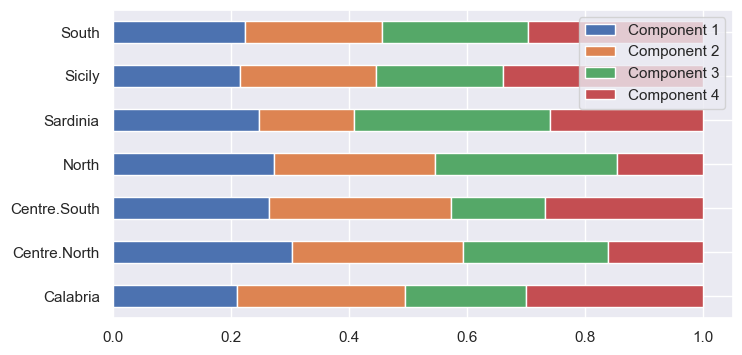

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

<Axes: xlabel='component', ylabel='concentration'>

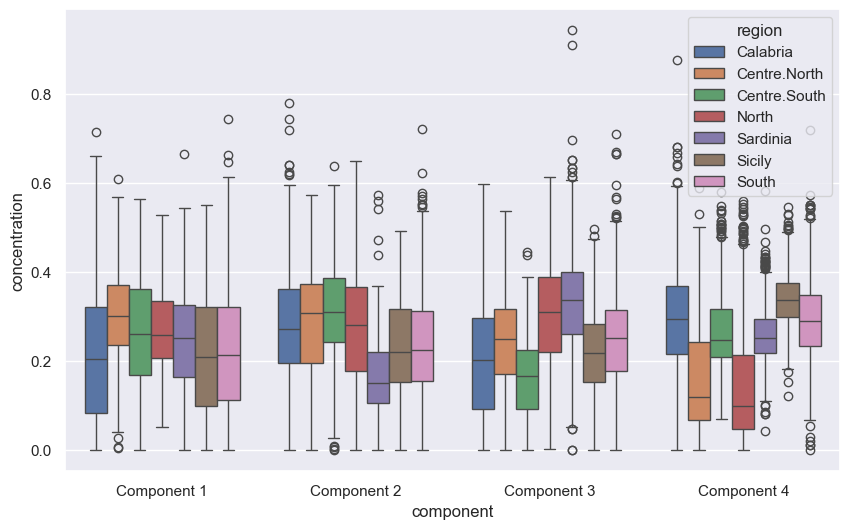

In [214]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='region',
)

<Axes: xlabel='month', ylabel='concentration'>

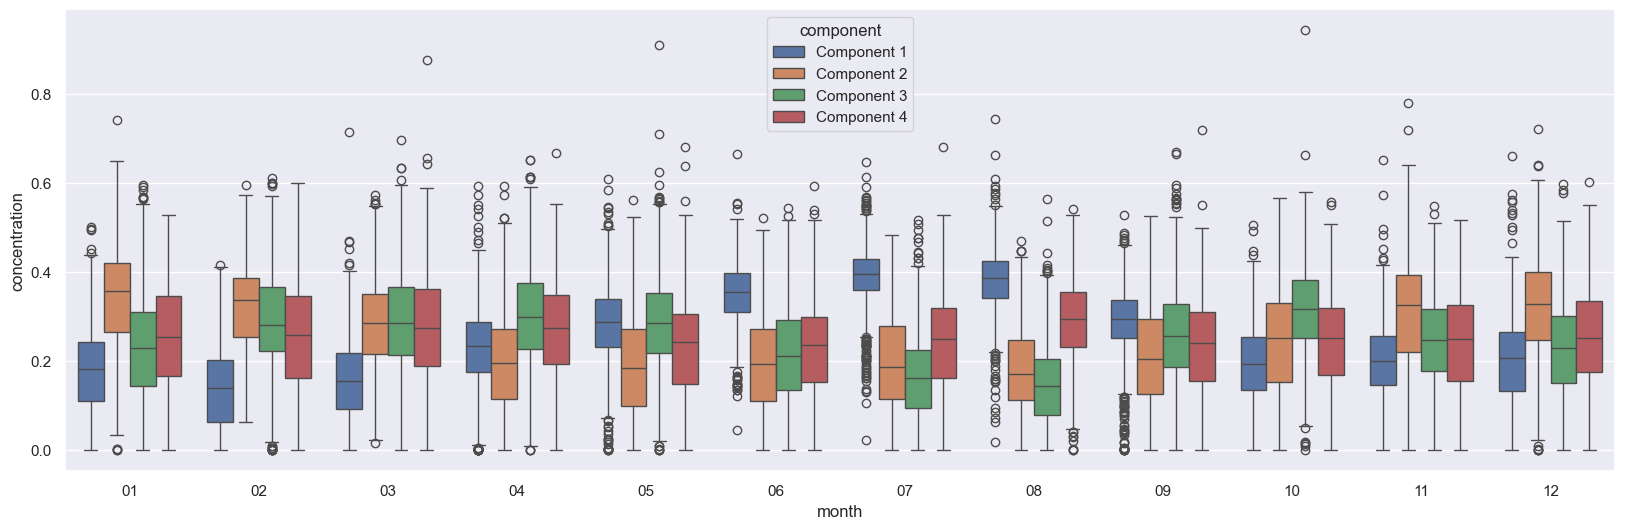

In [215]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

In [218]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

AttributeError: 'numpy.ndarray' object has no attribute 'melt'

<Figure size 1000x600 with 0 Axes>

## Save results

In [241]:
if smoothed:
    outfile = f'data/nmf_results/WHopt_{n_components}comp_smoothed_{n_runs}runs.npz'
else:
    outfile = f'data/nmf_results/WHopt_{n_components}comp_{n_runs}runs.npz'
np.savez(outfile, W=W, H=H)
print("Saved results at", outfile)

Saved results at data/nmf_results/WHopt_3comp_10000runs.npz


___

# TESTS

In [136]:
n_components_list = [3, 4]

for n_components in n_components_list:

    W_init = initialize_W(X, n_components)
    H_init = np.ones((n_components, p)) / p

    WH_init = np.dot(W_init, H_init)

    # Load the arrays from the .npz file
    data = np.load(f'data/nmf_results/uniform_{n_components}comp.npz')

    iterations = data['iterations']
    H_results = data['H_results'][..., iterations > 100]
    W_results = data['W_results'][..., iterations > 100]

    random_obs = random.randint(0, W_results.shape[2]-1)

    W_random = W_results[..., random_obs]
    H_random = H_results[..., random_obs]

    WH_random = np.dot(W_random, H_random)

    X_fpca = pd.read_csv(f'data/daily_curves_reconstructed_{n_components}PCs.csv', index_col=0)

    # Compute the Frobenius norm between X and the product W_init * H_init
    frobenius_norm_init = np.linalg.norm(X - WH_init, 'fro')
    frobenius_norm_final = np.linalg.norm(X - WH_random, 'fro')
    frobenius_norm_fpca = np.linalg.norm(X - X_fpca, 'fro')

    print(f'### {n_components} components ###')
    print("Frobenius Norm of the initial residual matrix:", frobenius_norm_init)
    print("Frobenius Norm of the final residual matrix:", frobenius_norm_final)
    print("Frobenius Norm of the FPCA residual matrix:", frobenius_norm_fpca)
    print('\n')

### 3 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.949199529377695
Frobenius Norm of the FPCA residual matrix: 0.7711263023212324


### 4 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.7607376211325353
Frobenius Norm of the FPCA residual matrix: 0.6634465209563668




In [36]:
errors[644]

0.6540102320810631

In [37]:
pd.Series(errors).quantile(np.linspace(0, 1, 21))

0.00    0.652081
0.05    0.653201
0.10    0.653387
0.15    0.653528
0.20    0.653644
0.25    0.653732
0.30    0.653810
0.35    0.653886
0.40    0.653961
0.45    0.654024
0.50    0.654114
0.55    0.654191
0.60    0.654272
0.65    0.654357
0.70    0.654444
0.75    0.654533
0.80    0.654648
0.85    0.654759
0.90    0.654923
0.95    0.655146
1.00    0.756661
dtype: float64

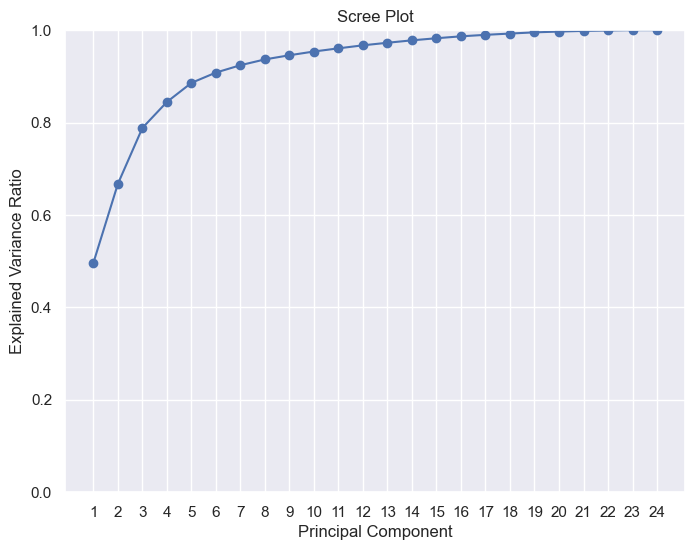

In [74]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
# plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.ylim((0,1))
plt.grid(True)
plt.show()

In [75]:
np.cumsum(pca.explained_variance_ratio_)

array([0.49630093, 0.66741324, 0.78837141, 0.84461045, 0.88591071,
       0.90821743, 0.92415001, 0.93673463, 0.94572021, 0.95382268,
       0.96067938, 0.96721481, 0.97276266, 0.97799972, 0.98254862,
       0.98667156, 0.98989461, 0.99267498, 0.99526384, 0.99697613,
       0.99841413, 0.99930394, 1.        , 1.        ])

In [57]:
# Perform PCA
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X)

In [58]:
pca.n_components_

23